In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os, sys

### Load dataset

MNIST

In [3]:
from tensorflow.keras.datasets import mnist

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
X_train, X_test = X_train / 255.0 * 2 - 1, X_test / 255.0 * 2 - 1 # Standardize image in range -1 to 1

In [6]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (60000, 28, 28)
X_test.shape: (10000, 28, 28)
y_train.shape: (60000,)
y_test.shape: (10000,)


### Data Preparation

In [7]:
N, H, W = X_train.shape
D = H * W # height x width dimensionn in 1 vector -> flatten
X_train = X_train.reshape(-1, D)
X_test = X_test.reshape(-1, D)

print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')

X_train.shape: (60000, 784)
X_test.shape: (10000, 784)


In [8]:
latent_dim = 100 # input dimension generator

### Build Model

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD

In [10]:
def build_discriminator(img_size): #img_size after flatten (H x W)
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x) # real of fake class
    
    model = Model(i, x)
    return model

In [11]:
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(D, activation='tanh')(x) # tanh because range value of image -1 to 1

    model = Model(i, x)
    return model

Compile Model

In [12]:
# build and compile discriminator
discriminator = build_discriminator(D)
discriminator.summary()
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [13]:
# build and compile generator
# generator compiled when using generator + discriminator because generator works by generator + discriminator(freeze)
generator = build_generator(latent_dim)

input_layer = Input(shape=(latent_dim,)) # input gan layer
img_layer = generator(input_layer)
discriminator.trainable = False

fake_pred_layer = discriminator(img_layer) # output gan layer

gan = Model(input_layer, fake_pred_layer)
gan.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
functional_3 (Functional)    (None, 784)               1493520   
_________________________________________________________________
functional_1 (Functional)    (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [14]:
gan.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5)
)

### Train Model

In [15]:
# config
batch_size = 32
epochs = 30000
sample_period = 200 # every sample_period steps save data

In [16]:
# batch labels
# either all ones or all zeros
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

In [17]:
# loss variable for generator and discriminator
g_losses = []
d_losses = []

In [18]:
# create image dir to save
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [19]:
# function to show image in grid rows x cols and save image based on epoch number
def save_sample(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)

    # rescale image to 0-1
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray') # from flat H*W to H x W matrix
            axs[i,j].axis('off')
            idx += 1
    
    fig.savefig(f'gan_images/{epoch}.png')
    plt.close()

In [20]:
for epoch in range(epochs):
    # TRAIN DISCRIMINATOR

    # get random image from train data
    idx_train = np.random.randint(0, X_train.shape[0], batch_size)
    real_imgs = X_train[idx_train]

    # generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)

    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)

    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    # TRAIN GENERATOR
    n_train_generator = 2
    g_loss = 0
    for i in range(n_train_generator):
        noise = np.random.randn(batch_size, latent_dim)
        g_loss = gan.train_on_batch(noise, ones)
    
    # save losses
    g_losses.append(g_loss)
    d_losses.append(d_loss)

    if epoch % 100 == 0:
        print(f'epoch: {epoch+1}/{epochs}, d_loss:{d_loss:.3f}, d_acc:{d_acc:.3f}, g_loss: {g_loss:.3f}')

    if epoch % sample_period == 0:
        save_sample(epoch)

epoch: 1/30000, d_loss:0.929, d_acc:0.500, g_loss: 1.035
epoch: 101/30000, d_loss:0.032, d_acc:1.000, g_loss: 3.938
epoch: 201/30000, d_loss:0.845, d_acc:0.453, g_loss: 1.059
epoch: 301/30000, d_loss:0.710, d_acc:0.469, g_loss: 0.579
epoch: 401/30000, d_loss:0.692, d_acc:0.500, g_loss: 0.630
epoch: 501/30000, d_loss:0.666, d_acc:0.500, g_loss: 0.657
epoch: 601/30000, d_loss:0.689, d_acc:0.609, g_loss: 0.670
epoch: 701/30000, d_loss:0.680, d_acc:0.453, g_loss: 0.651
epoch: 801/30000, d_loss:0.678, d_acc:0.469, g_loss: 0.688
epoch: 901/30000, d_loss:0.673, d_acc:0.469, g_loss: 0.708
epoch: 1001/30000, d_loss:0.660, d_acc:0.578, g_loss: 0.734
epoch: 1101/30000, d_loss:0.691, d_acc:0.516, g_loss: 0.750
epoch: 1201/30000, d_loss:0.673, d_acc:0.578, g_loss: 0.781
epoch: 1301/30000, d_loss:0.681, d_acc:0.578, g_loss: 0.761
epoch: 1401/30000, d_loss:0.681, d_acc:0.594, g_loss: 0.783
epoch: 1501/30000, d_loss:0.676, d_acc:0.625, g_loss: 0.746
epoch: 1601/30000, d_loss:0.625, d_acc:0.688, g_loss

### Model Evaluation

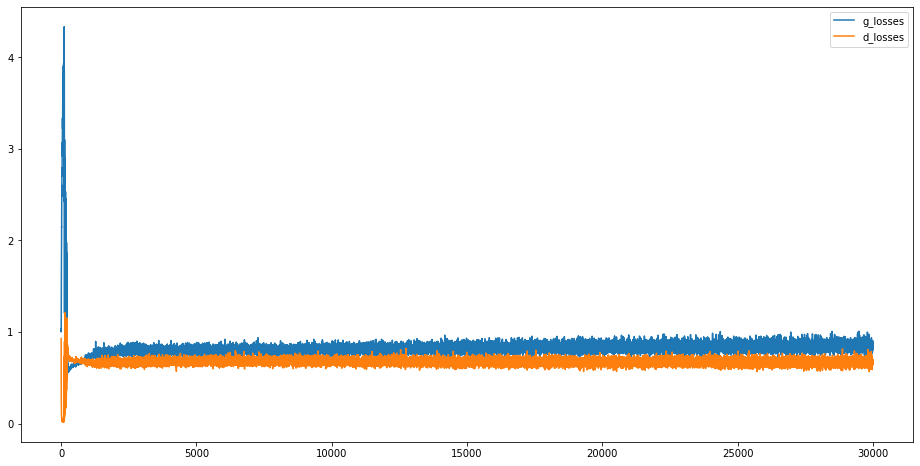

In [21]:
plt.figure(figsize=(16, 8))
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()
plt.show()

Sample Image

In [22]:
from skimage.io import imread

In [25]:
sample_result = ['0', '200', '1000', '5000', '15000', '29800']

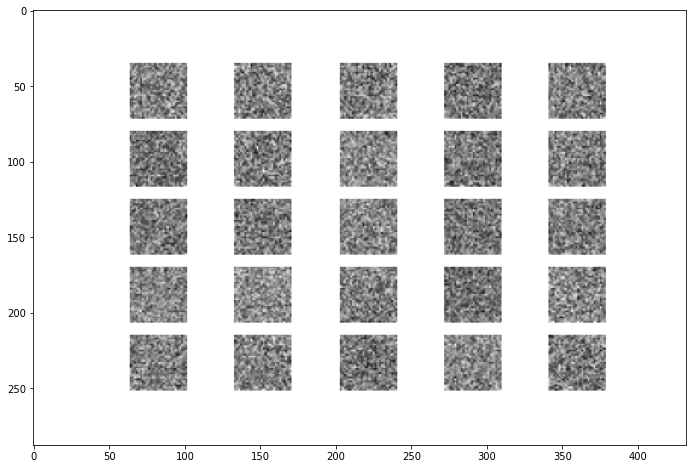

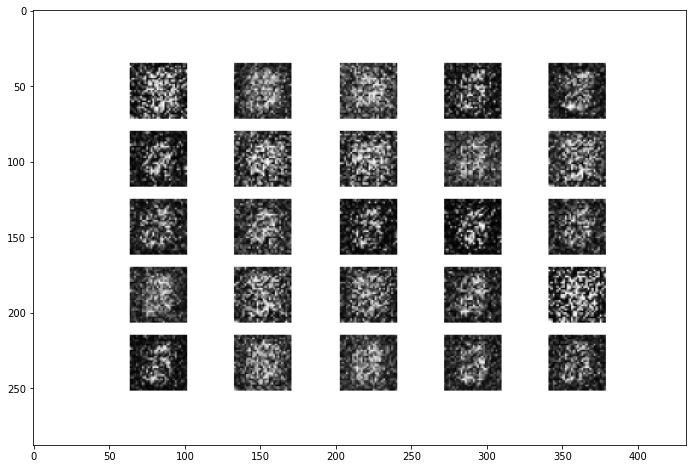

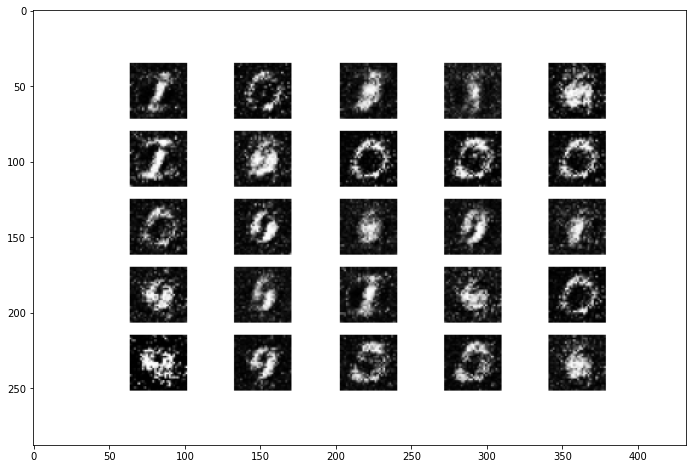

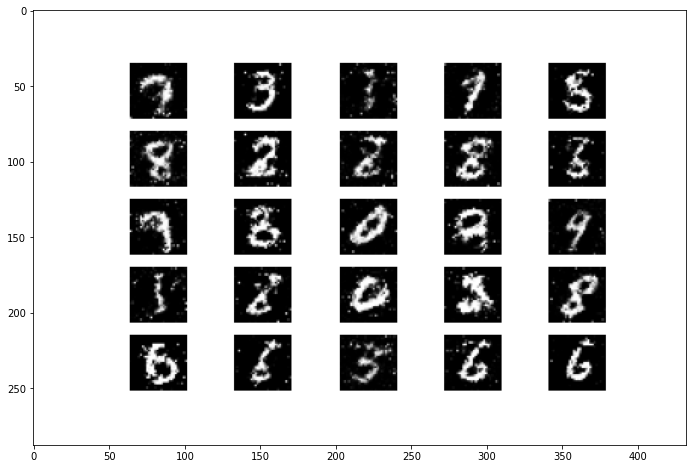

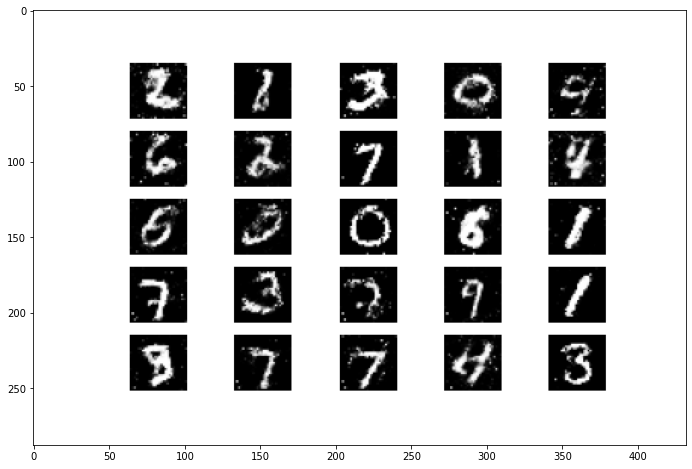

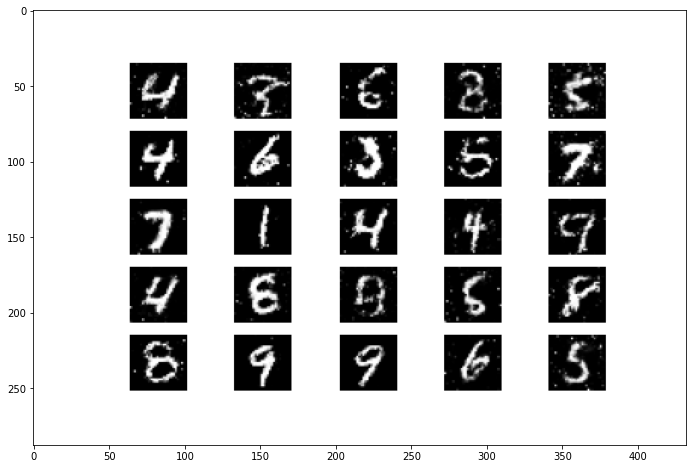

In [26]:
for sample in sample_result:
    a = imread('gan_images/' + sample + '.png')
    plt.figure(figsize=(16, 8))
    plt.imshow(a)
    plt.show()